# Diabetic patients readmission rates preditction


In [ ]:
# !pip install tqdm
# !pip install tensorflow
# !pip install umap-learn

In [1]:
# Importing package
#Standard Python libraries for data and visualisation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
import seaborn as sns; sns.set()

#sklearn packages for machine learning
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix

#pytorch packages for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import Dataset

%matplotlib inline


# Project introduction

- Overview: <br>
This project is focusing on developing a predictive model to ascertain the likelihood of readmission for diabetes patients.
<br>

- Target:<br>
The main goal of this project is developing a powerful machine learning model which can predict the readmission rate of patient 

# Data loading
The following cells are used to load training and testing data for our prediction

In [861]:
train_data = pd.read_csv("Dataset/diabetic_data_training.csv")
test_data = pd.read_csv("Dataset/diabetic_data_test.csv")
mapping_info = pd.read_csv("Dataset/IDS_mapping.csv", header=None)
pd.set_option('display.max_columns', None)

In [862]:
# Function to handle different data types for plotting
def plot_column(ax, column, df):
    if df[column].dtype == 'object':
        # Check if binary
        if df[column].nunique() == 2:
            # Binary data visualization
            df[column].value_counts().plot(kind='bar', ax=ax)
        else:
            # Categorical data visualization
            df[column].value_counts().plot(kind='pie', autopct='%1.1f%%', ax=ax)
    elif df[column].dtype == 'int64' or df[column].dtype == 'float64':
        # Numeric data visualization
        df[column].plot(kind='hist', bins=20, ax=ax)
    else:
        ax.text(0.5, 0.5, f"Unhandled data type for column: {column}", 
                fontsize=12, ha='center')
    ax.set_title(column)



# Data preprocessing
The following cells are used to preprocess the training and testing data. There are two main goals in our preprocessing data section of the code
- Change the string type data in our dataset to integer type data 
- Apply some applicable method to full up the missing value

In [863]:
# this part is used to change all string type data to integer type
# for the missing value, we will skip and process it at next step

df = train_data.copy()
df_test = test_data.copy()

In [864]:
#creating new column duplicate which contains whether the row is duplicated or not. It is boolean.
df['duplicate'] = df['patient_nbr'].duplicated()
#only those rows which are not duplicated are kept in the dataset.
df = df[df['duplicate'] == False]

#the duplicate column is dropped.
df = df.drop(['duplicate'], axis = 1)

One-Hot Encoding For race:
cons: One-hot encoding can lead to a significant increase in the dataset's dimensionality (a problem known as the "curse of dimensionality"), especially if the categorical feature has many unique values. This can increase the computational cost and may require more data to achieve good performance.
Dems Redct Would be apply, so it doesn't matter
pros: Map to a fix number implies an ordinal relationship between the categories which may not exist, but is ideal for non-ordinal categorical data. It's suitable for many machine learning models, especially those that assume no ordinal relationship between categories

Race Process
1. Remove missing since race is proved to be a significant impact to medical result.
2. One-hot encode race

In [865]:
def race_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    race_mask = (df['race'] != "?")
    df = df[race_mask]
    return df

In [866]:
df = race_filter(df)
df_encoded = pd.get_dummies(df, columns=["race"], prefix="race",dtype=int)

df_test = race_filter(df_test)
df_test_encoded = pd.get_dummies(df_test, columns=["race"], prefix="race",dtype=int)

Gender Process

1. Remove Unknown/Invalid and missing
2. One hot encode Gender

In [867]:
def gender_filter(df):
    """
    Remove missing value from race
    
    Parameters:
    df (pandas.dataframe): series containing a colum of the feature matrix.

    Return:
    Filtered dataframe free from ? for race
    """
    gender_mask = (df['gender'] != "Unknown/Invalid")
    df = df[gender_mask]
    return df

In [868]:
df_encoded = gender_filter(df_encoded)
df_test_encoded = gender_filter(df_test_encoded)
gender_mapping = {'Male':0,'Female':1}
df_encoded['gender'] = df_encoded['gender'].map(gender_mapping)
df_test_encoded['gender'] = df_test_encoded['gender'].map(gender_mapping)

encounter_id and patient_nbr Process 
1. n/a
2. Drop since it provide no info to the result

In [869]:
df_encoded.drop(columns=['encounter_id','patient_nbr'], inplace=True)
df_test_encoded.drop(columns=['encounter_id','patient_nbr'],inplace=True)

Age Process
1. n/a
2. Map age from range to mean

In [870]:
df_encoded['age'] = (df['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2
df_test_encoded['age'] = (df_test['age'].str.extract(r'(\d+)-(\d+)')[0].astype(int)+df_test['age'].str.extract(r'(\d+)-(\d+)')[1].astype(int))//2

Weight Process
1. Drop Weight for too many missing values and no information to predict.
2. n/a

In [871]:
df_encoded.drop(columns=['weight'], inplace=True)
df_test_encoded.drop(columns=['weight'], inplace=True)

num_lab_procedures num_procedures num_medications number_outpatient number_emergency number_inpatient No need to be encode since no missing and integer.

diag_1,diag_2 and diag_3 Process:

Filte diag_1, diag_2 and diag_3 by number_diagnoses. If the amount of diagnoses in diag_1, diag_2 and diag_3 doesn't match the number_diagnoses, then remove.
Layer encoding diags according to the ICD-9 Code Category, drop original 3 diag

In [872]:
def diag_missing_value_filter(df):

    df['number_diagnoses'] = pd.to_numeric(df['number_diagnoses'], errors='coerce')
    mask = ((df['number_diagnoses'] <= 3) & (
            (3 - df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) >= df['number_diagnoses'])) | (
    (df['number_diagnoses'] > 3) & (df[['diag_1', 'diag_2', 'diag_3']].apply(lambda x: x == "?").sum(axis=1)) == 0) 
    df_filtered = df[mask].copy()

    return df_filtered

def diag_layer_encoding(df):

    # Define the encoding function
    def encode_element(element):
        encoding_result = [0] * 20  # Default encoding

        if pd.notna(element):
            if element[0].isdigit():
                element = float(element)
                # Encode based on numeric range
                if 1 <= element <= 139:
                    encoding_result[0] = 1
                elif 140 <= element <= 239:
                    encoding_result[1] = 1
                elif 240 <= element <= 279:
                    encoding_result[2] = 1
                elif 280 <= element <= 289:
                    encoding_result[3] = 1
                elif 290 <= element <= 319:
                    encoding_result[4] = 1
                elif 320 <= element <= 389:
                    encoding_result[5] = 1
                elif 390 <= element <= 459:
                    encoding_result[6] = 1
                elif 460 <= element <= 519:
                    encoding_result[7] = 1
                elif 520 <= element <= 579:
                    encoding_result[8] = 1
                elif 580 <= element <= 629:
                    encoding_result[9] = 1
                elif 630 <= element <= 679:
                    encoding_result[10] = 1
                elif 680 <= element <= 709:
                    encoding_result[11] = 1
                elif 710 <= element <= 739:
                    encoding_result[12] = 1
                elif 740 <= element <= 759:
                    encoding_result[13] = 1
                elif 760 <= element <= 779:
                    encoding_result[14] = 1
                elif 780 <= element <= 799:
                    encoding_result[15] = 1
                elif 800 <= element <= 999:
                    encoding_result[16] = 1
                # Add more conditions for other ranges if needed
            elif element[0].isalpha():
                # Encode based on string prefix
                if element.startswith('E'):
                    encoding_result[17] = 1
                elif element.startswith('V'):
                    encoding_result[18] = 1
                elif element.startswith('M'):
                    encoding_result[19] = 1
                # Add more conditions for other prefixes if needed

        return encoding_result

    for i in range(1,4):
        encoded_columns = df["diag_"+str(i)].apply(encode_element)

    # Create new columns with "diag_1" as a prefix
        for j in range(20):
            new_column_name = "diag_" + str(i)+"_"+ str(j+1)
            df[new_column_name] = encoded_columns.apply(lambda x: x[j])

    return df


In [873]:
df_encoded = diag_missing_value_filter(df_encoded)
df_encoded = diag_layer_encoding(df_encoded)
df_test_encoded = diag_missing_value_filter(df_test_encoded)
df_test_encoded = diag_layer_encoding(df_test_encoded)

for i in range(1,4):
        df_encoded.drop(columns=[f'diag_{i}'], inplace=True)
        df_test_encoded.drop(columns=[f'diag_{i}'], inplace=True)

number_diagnoses pass since no missing and integer max_glu_serum and A1Cresult Process: 
1. n/a 
2. index map to 0-3



In [874]:
max_glu_serum_mapping = {'>200': 2, '>300': 3, 'normal': 1}
A1Cresult_mapping = {'>8':3,'>7':2,'normal':1}

In [875]:
df_encoded['max_glu_serum'] = df_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)
df_test_encoded['max_glu_serum'] = df_test_encoded['max_glu_serum'].map(max_glu_serum_mapping).fillna(0)

df_encoded["A1Cresult"] = df_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)
df_test_encoded["A1Cresult"] = df_test_encoded['A1Cresult'].map(A1Cresult_mapping).fillna(0)

metformin repaglinide nateglinide chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide examide citoglipton insulin glyburide-metformin glipizide-metformin glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone Process:

1. drop 'examide', 'citoglipton','glimepiride-pioglitazone' and 'metformin-rosiglitazone' since single value observed
2. index map to 0-3

In [876]:
df_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
df_test_encoded.drop(columns=['examide', 'citoglipton','glimepiride-pioglitazone','metformin-rosiglitazone'],axis=1,inplace=True)
medics = ['metformin','repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
        'metformin-pioglitazone']
for i in medics:
    df_encoded.loc[df_encoded[i] == 'Up', [i]] = 3  
    df_encoded.loc[df_encoded[i] == 'Down', [i]] = 1 
    df_encoded.loc[df_encoded[i] == 'Steady', [i]] = 2 
    df_encoded.loc[df_encoded[i] == 'No', [i]] = 0
    df_test_encoded.loc[df_test_encoded[i] == 'Up', [i]] = 3  
    df_test_encoded.loc[df_test_encoded[i] == 'Down', [i]] = 1 
    df_test_encoded.loc[df_test_encoded[i] == 'Steady', [i]] = 2 
    df_test_encoded.loc[df_test_encoded[i] == 'No', [i]] = 0 
 

change and diabetesMed Process

1. n/a
2. binary map to 1/0

In [877]:
change_mapping = {'No':0,'Ch':1}
diabetesMed_mapping = {'No':0,'Yes':1}

df_encoded['change'] = df_encoded['change'].map(change_mapping)
df_encoded['diabetesMed'] = df_encoded['diabetesMed'].map(diabetesMed_mapping)

df_test_encoded['change'] = df_test_encoded['change'].map(change_mapping)
df_test_encoded['diabetesMed'] = df_test_encoded['diabetesMed'].map(diabetesMed_mapping)

readmitted Process: 
1. n/a 
2. index mapping, No as 0, >30 as 1 and <30 as most significant as 2 and drop readmitted for test

In [878]:
readmitted_mapping = {'NO':0,'<30':2,'>30':1}
df_encoded['readmitted'] = df_encoded['readmitted'].map(readmitted_mapping)
df_test_encoded['readmitted'] = df_test_encoded['readmitted'].map(readmitted_mapping)

y_readmitted = df_encoded["readmitted"]
y_test_readmitted = df_test_encoded["readmitted"]

df_encoded.drop(columns=["readmitted"],axis=1,inplace=True)
df_test_encoded.drop(columns=["readmitted"],axis=1,inplace=True)

'admission_type_id','discharge_disposition_id','admission_source_id' Process:
1. n/a
2. target encoding

In [879]:
X_train = df_encoded
Y_train = y_readmitted

features = ['admission_type_id','discharge_disposition_id','admission_source_id']

'''for name in names:
    category_means = df_encoded.groupby(name)['readmitted'].mean().reset_index()
    category_means.columns = [name,name+'_readmitted_Mean']
    df_encoded = pd.merge(df_encoded, category_means, on=name, how='left')
    df_encoded = df_encoded.drop(name, axis=1)'''


for feature in features:
    
    mean_col_name = f'{feature}_Encoded'
    means = X_train.join(Y_train).groupby(feature)['readmitted'].mean()
    df_encoded[mean_col_name] = df_encoded[feature].map(means)
    df_test_encoded[mean_col_name] = df_test_encoded[feature].map(means)

    df_encoded = df_encoded.drop(feature, axis=1)
    df_test_encoded = df_test_encoded.drop(feature, axis=1)

Payer Code Process:

1.2 RandomForestClassifier fill missing
1.3 KNN filling missing

2. index encoding payer code

In [880]:
def payer_code_index_encoding(df):
    df.loc[df['payer_code'] == 'MD', ['payer_code']] = 1
    df.loc[df['payer_code'] == 'MC', ['payer_code']] = 2
    df.loc[df['payer_code'] == 'HM', ['payer_code']] = 3
    df.loc[df['payer_code'] == 'UN', ['payer_code']] = 4
    df.loc[df['payer_code'] == 'BC', ['payer_code']] = 5
    df.loc[df['payer_code'] == 'CP', ['payer_code']] = 6
    df.loc[df['payer_code'] == 'SP', ['payer_code']] = 7
    df.loc[df['payer_code'] == 'SI', ['payer_code']] = 8
    df.loc[df['payer_code'] == 'CM', ['payer_code']] = 9
    df.loc[df['payer_code'] == 'DM', ['payer_code']] = 10
    df.loc[df['payer_code'] == 'CH', ['payer_code']] = 11
    df.loc[df['payer_code'] == 'PO', ['payer_code']] = 12
    df.loc[df['payer_code'] == 'WC', ['payer_code']] = 13
    df.loc[df['payer_code'] == 'OG', ['payer_code']] = 14
    df.loc[df['payer_code'] == 'OT', ['payer_code']] = 15
    df.loc[df['payer_code'] == 'MP', ['payer_code']] = 16
    df.loc[df['payer_code'] == 'FR', ['payer_code']] = 17
    return df

In [881]:
df_encoded = payer_code_index_encoding(df_encoded)
df_test_encoded = payer_code_index_encoding(df_test_encoded)

In [882]:
#separating the columns that contain null values and need to predicted.
payer_code_col = ['payer_code']
other_cols = list(df_encoded.columns)
other_cols.remove("payer_code")
other_cols.remove("medical_specialty")

Random Forst

In [883]:
payer_code_mask = (df_encoded["payer_code"] != "?")
df_notnans = df_encoded[payer_code_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans[payer_code_col].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)

In [884]:


# rf = RandomForestClassifier()
# paramsgrid  = {'n_estimators': [100,200,400],
#                'max_depth': [25, 30,50,100],
#  'min_samples_leaf': [1, 2, 3],
#  'min_samples_split': [2, 5, 10]
#  }

# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
# rf_random.fit(X_test, y_test.values.ravel())

In [885]:
# rf_random.best_params_

In [886]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=1,min_samples_split=10))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5475635475635475


KNN filling

In [887]:
# train_score = []
# test_score = []

# for i in range(6,30,2):

#     knn = KNeighborsClassifier(i)
#     knn.fit(X_train,y_train.values.ravel())
    
#     train_score.append(knn.score(X_train,y_train.values.ravel()))
#     test_score.append(knn.score(X_test,y_test.values.ravel()))

In [888]:
# plt.plot(train_score)
# plt.plot(test_score)

In [889]:
# knn2 =(KNeighborsClassifier(n_neighbors= 21))
# # # Fit on the train data
# knn2.fit(X_train, y_train.values.ravel())

# # # Check the prediction score
# score = knn2.score(X_test, y_test.values.ravel())
# print(f"The score on the testset is {score}")

56>53, therefore use randomforst for medical_specialty and payercode

In [890]:
payer_code_mask = (df_encoded["payer_code"] == "?")
df_notnans = df_encoded[payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[payer_code_mask, 'payer_code'] = df_notnans['payer_code']


In [ ]:
test_payer_code_mask = (df_test_encoded["payer_code"] == "?")
df_notnans = df_test_encoded[test_payer_code_mask]
df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])
df_test_encoded.loc[test_payer_code_mask, 'payer_code'] = df_notnans['payer_code']


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/1322505668.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["payer_code"] = rf1.predict(df_notnans[other_cols])


medical_specialty Proces:
1. index encoding label
2. RF and KNN filling

In [ ]:
train_medical_specialty = df_encoded["medical_specialty"].unique()
test_medical_specialty = df_test_encoded["medical_specialty"].unique()

train_medical_specialty = list(train_medical_specialty)
train_medical_specialty.remove("?")
train_medical_specialty = set(train_medical_specialty)

test_medical_specialty = list(test_medical_specialty)
test_medical_specialty.remove("?")
test_medical_specialty = set(test_medical_specialty)

In [ ]:
medical_specialty_lable = train_medical_specialty.union(test_medical_specialty)

medical_specialty_nan_mask = (df_encoded['medical_specialty'] != "?")
medical_specialty_test_nan_mask = (df_test_encoded['medical_specialty'] != "?")

medical_specialty_dict = {element: index for index, element in enumerate(medical_specialty_lable)}


medical_specialty_test_to_be_encoded = df_test_encoded[medical_specialty_test_nan_mask]
medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])

medical_specialty_to_be_encoded = df_encoded[medical_specialty_nan_mask]
medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/2194747546.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_test_to_be_encoded['medical_specialty']= medical_specialty_test_to_be_encoded['medical_specialty'].map(lambda x: medical_specialty_dict[x])
/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/2194747546.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  medical_specialty_to_be_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_

In [ ]:
df_encoded['medical_specialty'] = medical_specialty_to_be_encoded['medical_specialty']
df_test_encoded['medical_specialty'] = medical_specialty_test_to_be_encoded['medical_specialty']


RF for medical_specialty

In [ ]:
medical_specialty_mask = df_encoded["medical_specialty"].notnull()
df_notnans = df_encoded[medical_specialty_mask]
X_train, X_test, y_train, y_test = train_test_split(df_notnans[other_cols], df_notnans["medical_specialty"].astype(int),
                                                    train_size=0.75,
                                                    random_state=1)


rf = RandomForestClassifier()
paramsgrid  = {'n_estimators': [100,200,400],
               'max_depth': [25, 30,50,100],
 'min_samples_leaf': [1, 2, 3],
 'min_samples_split': [2, 5, 10]
 }

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = paramsgrid, n_iter = 5, cv = 3, verbose=2, random_state=1, n_jobs = -1)
 
rf_random.fit(X_test, y_test.values.ravel())

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


520676.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.42s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.45s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.47s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.52s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
520676.53s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.2s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=100, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   4.0s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.7s
[CV] END max_depth=100, min_samples_leaf=2, min_samples_split=2, n_estimators=400; total time=   8.8s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   9.0s
[CV] END max_depth=100, min_samples_leaf=1, min_samples_split=10, n_estimators=40

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': [25, 30, 50, 100],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 400]},
                   random_state=1, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 100}

In [ ]:
rf1 =(RandomForestClassifier(max_depth=100,n_estimators = 400,min_samples_leaf=2,min_samples_split=2))
rf1.fit(X_train, y_train.values.ravel())
score = rf1.score(X_test, y_test.values.ravel())

print(f"Score is {score}")

Score is 0.5369945684972842


KNN for medical_specialty

In [ ]:
# train_score = []
# test_score = []

# for i in range(5,100,2):

#     knn = KNeighborsClassifier(i)
#     knn.fit(X_train,y_train.values.ravel())
#     trianscore = knn.score(X_train,y_train.values.ravel())
#     testscore = knn.score(X_test,y_test.values.ravel())
#     train_score.append(trianscore)
#     test_score.append(testscore)
#     print(f"train score is: {trianscore}, test score is: {testscore}")

In [ ]:
# plt.plot(train_score)
# plt.plot(test_score)

In [ ]:
# knn2 =(KNeighborsClassifier(n_neighbors= 25))
# # # Fit on the train data
# knn2.fit(X_train, y_train.values.ravel())

# # # Check the prediction score
# score = knn2.score(X_test, y_test.values.ravel())
# print(f"The score on the testset is {score}")

53>35, therefore use RF

In [ ]:
medical_specialty_code_mask = df_encoded["medical_specialty"].isna()
df_notnans = df_encoded[medical_specialty_code_mask]
df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])
df_encoded.loc[medical_specialty_code_mask, 'medical_specialty'] = df_notnans['medical_specialty']


/var/folders/wy/3sxd9blx6bxgs72tmypqqrzr0000gn/T/ipykernel_26725/2029475354.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])


In [ ]:
df_notnans['admission_source_id_Encoded'].value_counts()

admission_source_id_Encoded
0.521956    3046
0.469694    1163
0.528130     244
0.377645     185
0.456774     103
0.328400      46
0.442231      37
0.780142      14
0.561538      11
0.312500       1
0.250000       1
Name: count, dtype: int64

In [ ]:
medical_specialty_code_mask = df_test_encoded["medical_specialty"].isna()
df_notnans = df_test_encoded[medical_specialty_code_mask]
df_notnans["medical_specialty"] = rf1.predict(df_notnans[other_cols])
df_test_encoded.loc[medical_specialty_code_mask, 'medical_specialty'] = df_notnans['medical_specialty']


ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
df_encoded['medical_specialty'].value_counts()

medical_specialty
30.0    40719
8.0     11143
58.0    10153
47.0     8194
51.0     3845
        ...  
63.0        1
12.0        1
15.0        1
26.0        1
0.0         1
Name: count, Length: 72, dtype: int64

Normalization age, medical_specialty, num_lab_procedures and num_medications to keep the same order of magnitude

In [ ]:
from sklearn.feature_selection import SelectFromModel

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(df_encoded, y_readmitted)

feature_importances = pd.DataFrame(clf.feature_importances_, 
                                   index = df_encoded.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
                                  
feature_importances.head(10)
Selector = SelectFromModel(clf, prefit=True, threshold='mean')
X_selected = Selector.transform(df_encoded)
X_test_selected = Selector.transform(df_test_encoded)

selected_features = df_encoded.columns[(Selector.get_support())]

df_encoded = pd.DataFrame(X_selected, columns=selected_features)
df_test_encoded = pd.DataFrame(X_test_selected, columns=selected_features)


/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
features_to_scale = ["age","medical_specialty","num_lab_procedures","num_medications"]
df_encoded[features_to_scale] = scaler.fit_transform(df_encoded[features_to_scale])
df_test_encoded[features_to_scale] = scaler.fit_transform(df_test_encoded[features_to_scale])

In [ ]:
df_encoded

,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,race_AfricanAmerican,race_Caucasian,diag_1_7,diag_2_3,diag_2_7,diag_3_3,diag_3_7,admission_type_id_Encoded,discharge_disposition_id_Encoded,admission_source_id_Encoded
0,1,0.111111,3,1,0.422535,0.442748,0,0.2125,0,0,0,9,0.0,0,0,0,3,1,0,1,0,1,0,1,0,0.590542,0.547861,0.612805
1,1,0.222222,2,1,0.422535,0.076336,5,0.1500,2,0,1,6,0.0,0,2,0,0,0,1,0,0,1,0,0,0,0.590542,0.547861,0.612805
2,0,0.333333,2,7,0.422535,0.328244,1,0.1875,0,0,0,7,0.0,0,0,0,3,1,0,1,0,1,0,0,1,0.590542,0.547861,0.612805
3,0,0.444444,1,7,0.422535,0.381679,0,0.0875,0,0,0,5,0.0,0,2,0,2,1,0,1,0,0,0,1,0,0.590542,0.547861,0.612805
4,0,0.555556,3,2,0.661972,0.229008,6,0.1875,0,0,0,9,0.0,0,0,0,2,0,0,1,1,0,1,1,0,0.585561,0.547861,0.501625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89356,0,0.777778,3,2,0.422535,0.381679,0,0.1875,0,0,0,9,3.0,2,0,0,1,1,1,0,0,0,0,0,1,0.590542,0.645172,0.612805
89357,1,0.888889,5,2,0.422535,0.244275,3,0.2125,0,0,1,9,0.0,0,0,0,2,0,1,0,0,1,0,0,0,0.590542,0.590116,0.497333
89358,0,0.777778,1,2,0.422535,0.396947,0,0.1000,1,0,0,13,0.0,2,0,0,1,1,0,1,0,0,0,0,0,0.590542,0.547861,0.612805
89359,1,0.888889,10,2,0.718310,0.335878,2,0.2500,0,0,1,9,0.0,0,2,0,3,1,0,1,0,0,0,0,0,0.585561,0.645172,0.612805


In [ ]:
df_encoded.to_csv('encoded_train.csv',index=False)
df_test_encoded.to_csv('encoded_test.csv',index=False)
y_readmitted.to_csv('y_readmitted.csv',index=False)
y_test_readmitted.to_csv('y_test_readmitted.csv',index=False)

In [ ]:
df_encoded = pd.read_csv('encoded_train.csv')
df_test_encoded = pd.read_csv('encoded_test.csv')


In [ ]:
y_readmitted = pd.read_csv('y_readmitted.csv').to_numpy()
y_test_readmitted = pd.read_csv('y_test_readmitted.csv').to_numpy()

In [ ]:
df_encoded

,gender,age,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,A1Cresult,metformin,glipizide,glyburide,insulin,change,race_AfricanAmerican,race_Caucasian,diag_1_7,diag_2_3,diag_2_7,diag_3_3,diag_3_7,admission_type_id_Encoded,discharge_disposition_id_Encoded,admission_source_id_Encoded
0,1,0.111111,3,1,0.422535,0.442748,0,0.2125,0,0,0,9,0.0,0,0,0,3,1,0,1,0,1,0,1,0,0.590542,0.547861,0.612805
1,1,0.222222,2,1,0.422535,0.076336,5,0.1500,2,0,1,6,0.0,0,2,0,0,0,1,0,0,1,0,0,0,0.590542,0.547861,0.612805
2,0,0.333333,2,7,0.422535,0.328244,1,0.1875,0,0,0,7,0.0,0,0,0,3,1,0,1,0,1,0,0,1,0.590542,0.547861,0.612805
3,0,0.444444,1,7,0.422535,0.381679,0,0.0875,0,0,0,5,0.0,0,2,0,2,1,0,1,0,0,0,1,0,0.590542,0.547861,0.612805
4,0,0.555556,3,2,0.661972,0.229008,6,0.1875,0,0,0,9,0.0,0,0,0,2,0,0,1,1,0,1,1,0,0.585561,0.547861,0.501625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89356,0,0.777778,3,2,0.422535,0.381679,0,0.1875,0,0,0,9,3.0,2,0,0,1,1,1,0,0,0,0,0,1,0.590542,0.645172,0.612805
89357,1,0.888889,5,2,0.422535,0.244275,3,0.2125,0,0,1,9,0.0,0,0,0,2,0,1,0,0,1,0,0,0,0.590542,0.590116,0.497333
89358,0,0.777778,1,2,0.422535,0.396947,0,0.1000,1,0,0,13,0.0,2,0,0,1,1,0,1,0,0,0,0,0,0.590542,0.547861,0.612805
89359,1,0.888889,10,2,0.718310,0.335878,2,0.2500,0,0,1,9,0.0,0,2,0,3,1,0,1,0,0,0,0,0,0.585561,0.645172,0.612805


Dems Redct
1. PCA/PPCA
2. LDA/QDA
3. following to T-SNE
3. Autoencoders
4. Unsupervised Algorithmn

In [ ]:
               
def plot_2d(projected, y_train, title):
    fig = plt.figure(figsize=(8, 6), dpi=80)
    ax = fig.add_subplot(111)

    p = ax.scatter(projected[:, 0], projected[:, 1],
                c=y_train, edgecolor='none', alpha=0.5,
                  cmap='tab10')
    ax.set_xlabel('component 1')
    ax.set_ylabel('component 2')
    ax.set_title(title)
    fig.colorbar(p);
    
def print_results(y_pred, y_test):
    mat = confusion_matrix(y_test, y_pred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');

    print("Accuracy on test set: ", accuracy_score(y_test, y_pred))


Correlation

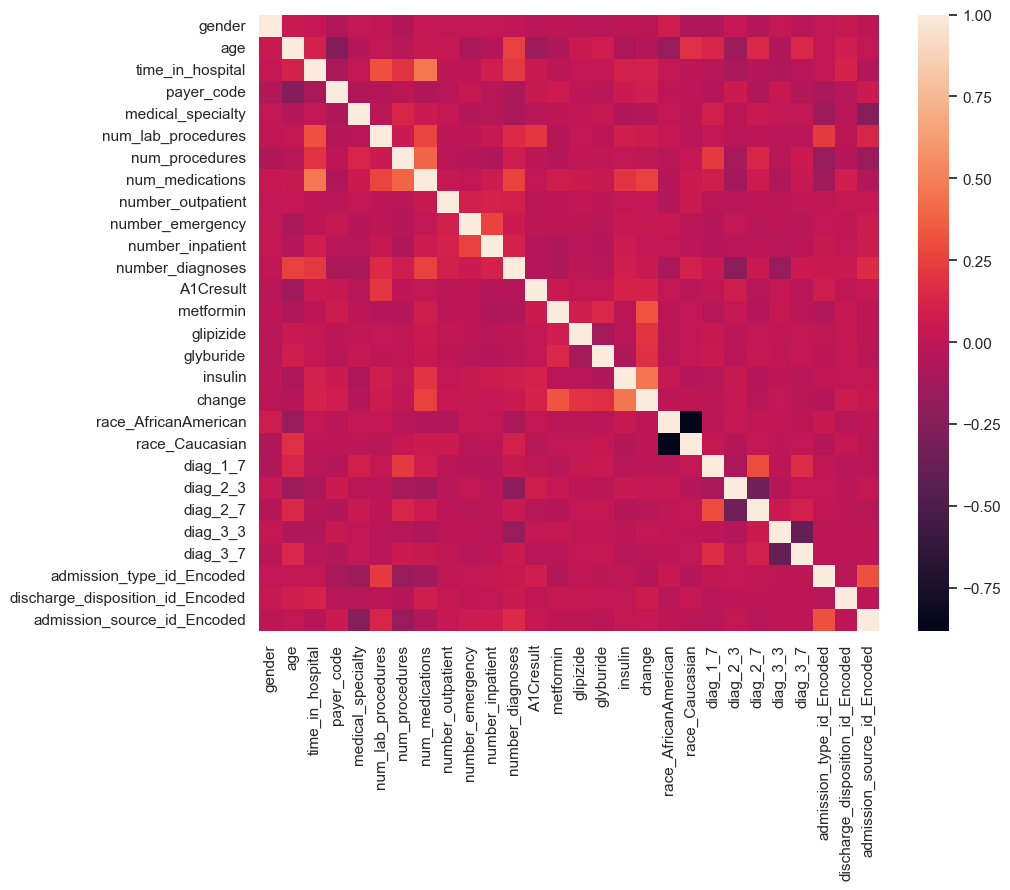

In [ ]:
corr = df_encoded.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

In [ ]:
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_result = pca.fit_transform(df_encoded)
test_pca_result = pca.fit_transform(df_test_encoded)


Naive Bayes for demstionality reduction result evaluation, This algorithm is very fast and works well with high-dimensional data. It assumes independence between the features, which may or may not hold after dimensionality reduction. According to the covr graph, mostly independent.

In [ ]:
def naive_bayes_score(train, label, test, test_label):
    nb = GaussianNB()
    nb.fit(train, label)
    y_nb = nb.predict(test)
    mse = np.mean((test_label - y_nb) ** 2)
    accuracy = accuracy_score(y_nb,test_label)

    return mse, accuracy

In [ ]:
non_dr_score = naive_bayes_score(df_encoded,y_readmitted,df_test_encoded,y_test_readmitted)
print(f"Full param mse score is {non_dr_score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
Full param mse score is 0.8310350982657062


In [ ]:
pca_score = naive_bayes_score(pca_result,y_readmitted,test_pca_result,y_test_readmitted)
print(f"PCA mse score is {pca_score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
PCA mse score is 0.7946666240292409


In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(df_encoded)

KeyboardInterrupt: 

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
tsne_test_result = tsne.fit_transform(df_test_encoded)

In [ ]:
tsne_score = naive_bayes_score(tsne_result,y_readmitted,tsne_test_result,y_test_readmitted)
print(f"tsne mse score is {tsne_score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
tsne mse score is 0.7911758498790953


UMAP

In [ ]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3, n_components=2)
umap_result = umap_model.fit_transform(df_encoded)
umap_test_result = umap_model.fit_transform(df_test_encoded)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [ ]:
umpa_score = naive_bayes_score(umap_result,y_readmitted,umap_test_result,y_test_readmitted)
print(f"umpa mse score is {umpa_score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
umpa mse score is 0.7914949230923897


PCA and t-sne

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
pca_tsne_trian_result = tsne.fit_transform(pca_result)

In [ ]:
tsne = TSNE(n_components=3, perplexity=30, n_iter=300)
pca_tsne_result = tsne.fit_transform(test_pca_result)

In [ ]:
pca_tsne_score = naive_bayes_score(pca_tsne_trian_result,y_readmitted,pca_tsne_result,y_test_readmitted)
print(f"pca-tsne mse score is {pca_tsne_score}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(9947,) (9947, 1)
pca-tsne mse score is 0.7901026036161961


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
# Number of features in your dataset
n_features = len(df_encoded.columns)  # Change this to the actual number of features

# Define the encoder
input_layer = Input(shape=(n_features,))
encoder = Dense(64, activation='relu')(input_layer)
encoder = Dense(32, activation='relu')(encoder)

# Define the bottleneck
bottleneck = Dense(10, activation='relu')(encoder)  # This is the latent space representation

# Define the decoder (mirror the encoder)
decoder = Dense(32, activation='relu')(bottleneck)
decoder = Dense(64, activation='relu')(decoder)

# Output layer
output_layer = Dense(n_features, activation='sigmoid')(decoder)  # Use 'sigmoid' or 'relu'

# Define the autoencoder model
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
df_encoded = df_encoded.astype('float32')
df_test_encoded = df_test_encoded.astype('float32')
autoencoder.fit(df_encoded, df_encoded,  # The target is the input data itself
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(df_test_encoded, df_test_encoded))

Epoch 1/200
699/699 [==============================] - 2s 2ms/step - loss: 3.0804 - val_loss: 3.0044
Epoch 2/200
699/699 [==============================] - 1s 1ms/step - loss: 3.0040 - val_loss: 2.9736
Epoch 3/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9856 - val_loss: 2.9653
Epoch 4/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9801 - val_loss: 2.9605
Epoch 5/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9765 - val_loss: 2.9586
Epoch 6/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9751 - val_loss: 2.9573
Epoch 7/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9741 - val_loss: 2.9571
Epoch 8/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9729 - val_loss: 2.9552
Epoch 9/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9723 - val_loss: 2.9578
Epoch 10/200
699/699 [==============================] - 1s 1ms/step - loss: 2.9720 - val_lo

In [ ]:
encoder_model = Model(inputs=input_layer, outputs=bottleneck)
compressed_data = encoder_model.predict(df_encoded)
reconstructed_data = autoencoder.predict(df_encoded)

compressed_test_data = encoder_model.predict(df_test_encoded)
reconstructed_test_data = autoencoder.predict(df_test_encoded)

311/311 [==============================] - 0s 960us/step


In [ ]:
AE_score, accuracy = naive_bayes_score(reconstructed_data,y_readmitted,reconstructed_test_data,y_test_readmitted)
print(f"AE mse score is {AE_score}, AE accuracy score is {accuracy}")

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AE mse score is 0.7734944537505499, AE accuracy score is 0.5512214738111993


# Model Building
We will build two models: 
1. A traditional machine learning model using Random Forest.
2. A deep learning model using PyTorch.


At the first step we will try to use the Random Forest method to get the result

In [ ]:
'''
X = reconstructed_data
y = y_readmitted
X_test = reconstructed_test_data
y_test = y_test_readmitted


from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from collections import Counter

sm = SMOTE(random_state=42)
X, y = sm.fit_resample(X, y)
'''
X = df_encoded
y = y_readmitted
X_test = df_test_encoded
y_test = y_test_readmitted

In [ ]:
HGB_classifier = HistGradientBoostingClassifier(max_iter=100)
HGB_classifier.fit(X, y)
Y_pred = HGB_classifier.predict(X_test)
print(accuracy_score(y_test,Y_pred))

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5867095606715592


In [ ]:
pd.DataFrame(Y_pred).to_csv("temp.csv",index = False)

In [ ]:
# the code for Random Forest algorithm
from sklearn.feature_selection import SelectFromModel

RF_classifier = RandomForestClassifier(n_estimators=100)
RF_classifier.fit(X, y)

Y_pred = RF_classifier.predict(X_test)
print(accuracy_score(y_test,Y_pred))

/Users/szy/Downloads/yes/envs/COMP0169/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5757514828591536


array([0, 0, 0, ..., 0, 0, 1])

In [ ]:
X = pd.DataFrame(X)

In [ ]:
# the code for Nerual Network
class MLP(nn.Module):
    '''
    MLP class for predicting pixel values based on positions.
    '''
    def __init__(self, input_dimension, nb_layers, embedding_dimension, output_dimension):
        super(MLP, self).__init__()

        # Create a list to hold all layers
        layers = []

        # First layer
        layers.append(nn.Linear(input_dimension, embedding_dimension))
        layers.append(nn.Sigmoid())

        # Additional hidden layers
        for _ in range(nb_layers - 2):
            layers.append(nn.Linear(embedding_dimension, embedding_dimension))
            layers.append(nn.Sigmoid())

        # Output layer
        layers.append(nn.Linear(embedding_dimension, output_dimension))

        # Combine all layers
        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        # Pass the input through all layers
        prediction = self.layers(input)

        return prediction

model = MLP(len(X.columns),5,32,3)

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

def loss_function(predict,target):
    loss_func = nn.CrossEntropyLoss()
    return loss_func(predict,target) 


X_tensor = torch.tensor(X.values.astype(float), dtype=torch.float32)
df_y = pd.DataFrame(y)
Y_dl = pd.get_dummies(df_y[0])

y_tensor = torch.tensor(Y_dl.values.astype(float), dtype=torch.float32).squeeze(1)
print(y_tensor.shape)
print(y_tensor)


target_task_data = CustomDataset(X_tensor,y_tensor)  # Load your target task data
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = 'cpu'
model.to(device)
model.train()

for _ in range(50):
    for batch in tqdm(DataLoader(target_task_data, batch_size=1000, shuffle=True)):
        inputs, targets = batch
        optimizer.zero_grad()
        predictions = model(inputs)
        loss = loss_function(predictions, targets)
        loss.backward()
        optimizer.step()

if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/diabets_prediction.pth")

torch.Size([89361, 3])
tensor([[0., 1., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        ...,
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])


100%|██████████| 90/90 [00:00<00:00, 92.34it/s]


In [ ]:
X_test = pd.DataFrame(X_test)

In [ ]:
X_test_tensor = torch.tensor(X_test.values.astype(float),dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(float), dtype=torch.float32)
test_loader = TensorDataset(X_test_tensor, y_test_tensor)

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data in test_loader:  # 假设 test_loader 是测试数据的 DataLoader
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data,0)
        
        y_pred = predicted.item()
        total += 1
        if( y_pred == labels):
            correct += 1

accuracy = correct / total
print(accuracy)
print(correct)
print(total)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x28 and 50x40)

In [ ]:
# meta learning
np.random.seed(0)
torch.manual_seed(0)

# 模型配置
inner_lr = 0.01    # 内循环学习率
meta_lr = 0.001    # 元学习率
num_inner_updates = 1  # 每个任务的内部更新次数

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(50, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40,20),
            nn.Sigmoid(),
            nn.Linear(20, 3)
        )

    def forward(self, x):
        return self.fc(x)

def maml_train_step(model, optimizer, data_loader):
    meta_loss = 0

    for task_data in data_loader:
        # 拆分数据为支持集和查询集
        support_set, query_set = task_data
        x_support, y_support = support_set
        x_query, y_query = query_set

        # 保存原始参数以便在每个任务后恢复
        original_state_dict = model.state_dict()

        # 内循环：在支持集上训练
        for _ in range(num_inner_updates):
            y_pred = model(x_support)
            loss = nn.CrossEntropyLoss()(y_pred, y_support)
            model.zero_grad()
            loss.backward()
            # 仅使用内循环学习率更新参数
            for param in model.parameters():
                param.data -= inner_lr * param.grad.data

        # 外循环：在查询集上评估并更新元参数
        y_pred_query = model(x_query)
        query_loss = nn.CrossEntropyLoss()(y_pred_query, y_query)
        meta_loss += query_loss

        # 恢复模型到原始状态
        model.load_state_dict(original_state_dict)

    # 更新元参数
    optimizer.zero_grad()
    meta_loss.backward()
    optimizer.step()

    return meta_loss.item()

# 实例化模型和优化器
model = Model()
optimizer = optim.Adam(model.parameters(), lr=meta_lr)


X_tensor = torch.tensor(X.astype(float).values, dtype=torch.float32)
y_tensor = torch.tensor(y.astype(int).values, dtype=torch.long)
train_dataset = TensorDataset(X_tensor, y_tensor)

X_test_tensor = torch.tensor(X_test.astype(float).values,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.astype(int).values, dtype=torch.long)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_data_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

num_epochs = 10
# 训练循环（伪代码，需要根据实际情况调整）
for epoch in tqdm(range(num_epochs)):
    meta_loss = maml_train_step(model, optimizer, train_data_loader)
    print(f"Epoch {epoch}: Meta Loss {meta_loss}")

if not os.path.exists("models/"):
  os.makedirs("./models/")
torch.save({"model":model}, "models/diabets_prediction_meta_learning.pth")

AttributeError: 'numpy.ndarray' object has no attribute 'values'

# Model Training
